**Review**

Hello Eric!

I'm happy to review your project today.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there are some small problems that need to be fixed before the project will be accepted. Let me know if you have any questions!


In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255) #<add the other argument here>)

train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)

val_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

features, target = next(train_gen_flow)
print(features.shape)# < write code here >

Found 5694 validated image filenames.
Found 1897 validated image filenames.
(32, 224, 224, 3)


In [6]:
print(len(features))
print(len(target))

32
32


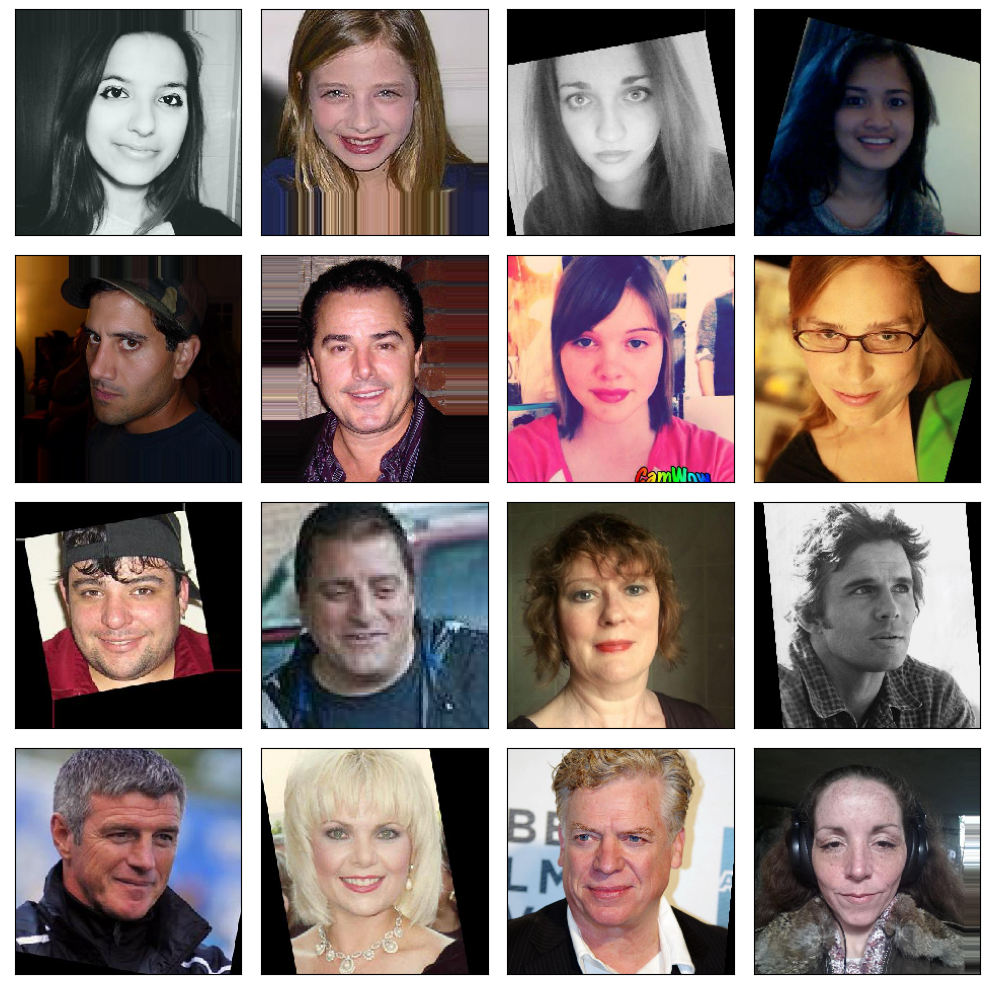

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [8]:
labels.head(16)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


## EDA

### labels EDA

In [9]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [10]:
labels.duplicated().sum()

0

In [11]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

There are no nulls or duplicates.

In [12]:
labels.dtypes

file_name    object
real_age      int64
dtype: object

In [13]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


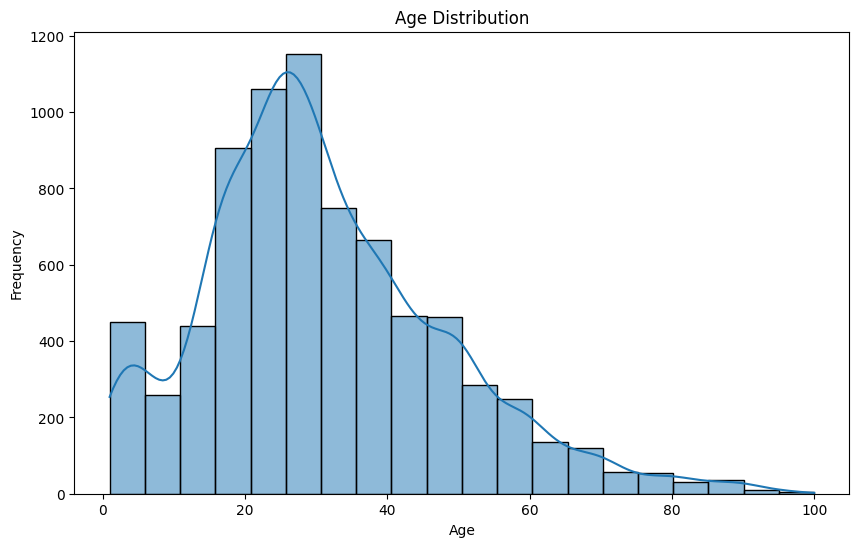

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Barring some unforeseen issue with the data that is tested below, I can change the datatype for age to np.int8, thereby reducing the memory needed for this dataframe.

In [15]:
np.array_equal(labels['real_age'], labels['real_age'].astype(np.int8))

True

We're good to go with the conversion which is accomplished and confirmed below.

In [16]:
labels['real_age'] = labels['real_age'].astype(np.int8)

In [17]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int8  
dtypes: int8(1), object(1)
memory usage: 66.8+ KB


In [18]:
labels['real_age'] = (labels['real_age'] - labels['real_age'].min()) / (labels['real_age'].max() - labels['real_age'].min())

In [19]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  7591 non-null   object 
 1   real_age   7591 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


Any memory minimization we gained by decreasing the int datatype for 'real_age' was lost when we norme\alized the ages to be a value between 0 and 1.

### Findings

Labels is a dataframe with a normal distribution of ages, peaking at age 31 as the mean. There are no duplicates or nulls. The aspect that I likely have to worry about is ensuring that the info from the labels dataframe is properly paired with the photos before model training. ImageDataGenerator for the photos were used to ensure that the photos were properly loaded, but this will be set up again in a below function. Image augmentatiotns like rotation and zoom would better train the model, especially since the images we can see from the sample of the directory show that there is sometimes a rotation or image augmentation effect with regards to the photo.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Everything is correct. Well done!

But what can you say about image augmentations? Like rotation, zoom and so on.

</div>

<div class="alert alert-info">
I added details about image augmentations in the markdown above.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Correct. Good job!

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [20]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [21]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    train_df = pd.read_csv(filepath_or_buffer=path + 'labels.csv')
     # I normalize the ages so they're between 0 and 1
    train_df['real_age'] = (train_df['real_age'] - train_df['real_age'].min()) / (train_df['real_age'].max() - train_df['real_age'].min())

    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True
    )
    
    train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=42
    )

    return train_gen

In [22]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    test_df = pd.read_csv(filepath_or_buffer=path + 'labels.csv')
    # I normalize the ages so they're between 0 and 1
    test_df['real_age'] = (test_df['real_age'] - test_df['real_age'].min()) / (test_df['real_age'].max() - test_df['real_age'].min())


    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )

    test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=42
    )

    return test_gen

<div class="alert alert-danger">
<b>Reviewer's comment</b>

1. You can't use additional function `setup_img_gen here` because it won't be included in your script according to the code below. Moreover ImageDataGenerator should be diffrent for train part and for test part because for test data you shoulnd't use any augmentations except rescaling
2. load_train and load_test functions should take only one argument `path`. Datasets should be loaded inside these functions using variable `path`
3. To load the dataset you should use a path: `path + 'labels.csv'`
4. For the argument `directory` you should use a path: `path + 'final_files/'`
5. You forgot to set arguments `subset` and `seed` in the both functions
6. You forgot to set argument `validation_split` in the ImageDataGenerator

</div>

<div class="alert alert-info">
I think I addressed all your points.
</div>

<div class="alert alert-danger">
<b>Reviewer's comment V2</b>

You addressed almost all my points:) The only one mistake is that you should create variables train_df and test_df inside the corresponding functions. Othewise you script will fail beacuse these variables won't be availabel in it. The path you should use to read this dataset is specified in my previous comment.
    


</div>

<div class="alert alert-info">
I addressed your concern.
</div>

In [23]:
def create_model(input_shape):
    
    """
    It defines model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

<div class="alert alert-danger">
<b>Reviewer's comment</b>

Please, copy this function from the lesson. You can't use your own custom model here.

</div>

<div class="alert alert-info">
This error has been corrected.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Correct

</div>

In [24]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

<div class="alert alert-danger">
<b>Reviewer's comment</b>

Please, copy this function from the lesson. It's not 100% correct

</div>

<div class="alert alert-info">
This error has been corrected.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Thank you!

</div>

In [ ]:
%%time

train_data = load_train("/datasets/faces/")
test_data = load_test("/datasets/faces/")
model = create_model((224,224,3)) # Parameter represents np size of image
history = train_model(model, train_data, test_data, epochs=1)

# I evaluate the model
loss, mae = model.evaluate(test_data, verbose=2)
print(f"Test loss: {loss}")
print(f"Test MAE: {mae}")

Found 5694 validated image filenames.
Found 1897 validated image filenames.


2024-09-05 12:15:22.504812: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


I input 1 epoch to the train function to try to limit the time and compututational resources required for this model, but this cell repeatedly killed the kernel. Therefore, the output that would usually be produced by this model was unavailable to provide at this place in the notebook.

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [25]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

<div class="alert alert-danger">
<b>Reviewer's comment</b>

To get the output in the proper formatting change the type of the previous cell from Markdown to Raw NBConvert, please.

</div>

<div class="alert alert-info">
This error has been corrected.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Well done!

</div>

The above represents the keras model run on a GPU over the course of 20 epochs.

## Conclusions

- The GPU model was able to run with 20 epochs which would have been impractical with mine. My model consistently crashed the Jupyter kernel with 1 epoch while running on a CPU.
- This model would be useful in any situation wherein you need to confirm the age of a customer/user/member. 
- This notebook shows the difference between running a computer vision model on a CPU vs. a GPU and how to go about training a model that ensures some level of image recognition. 

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training